- Author: Umair Khan
- Date: 15/06/20

# 1. Imports

In [1]:
import pandas as pd
from os.path import join
from shutil import copy2
from matplotlib import pyplot

# 2. Create Sample Dataset

In [2]:
def create_sample_set():
    root_path = "E:\\project\\data\\"
    sample_positive_path = "train_sample\\positive"
    sample_negative_path = "train_sample\\negative"
    csv_name = "train_labels.csv"
    label_df = pd.read_csv(join(root_path, csv_name), nrows=50000)

    positive_df = label_df[label_df['label'] == 1].head(5000)
    negative_df = label_df[label_df['label'] == 0].head(5000)
    copyfiles(join(root_path, 'train'), join(root_path, sample_positive_path), positive_df['id'].to_list())
    copyfiles(join(root_path, 'train'), join(root_path, sample_negative_path), negative_df['id'].to_list())
    df_merged = pd.concat([positive_df, negative_df], ignore_index=True)
    df_merged.to_csv('train_sample.csv', index=False)

def copyfiles(src, dst, img_files):
    for img_file in img_files:
        img_file_name = f'{img_file}.tif'
        copy2(join(src, img_file_name), dst)


# 3. Custom Load Function

In [3]:
from PIL import Image
import numpy as np
from os import listdir
from os.path import isfile

def load_sample_data():
    positive_path = "E:\project\gan_pcam\data\\train_sample\\positive"
    negative_path = "E:\project\gan_pcam\data\\train_sample\\negative"
    positive_images = [f for f in listdir(positive_path) if isfile(join(positive_path, f))]
    negative_images = [f for f in listdir(negative_path) if isfile(join(negative_path, f))]
    images = []
    labels = []
    for pos, neg in zip(positive_images, negative_images):
        img = Image.open(join(positive_path, pos))
        images.append(np.array(img))
        labels.append(1)
        img = Image.open(join(negative_path, neg))
        images.append(np.array(img))
        labels.append(0)
    return np.array(images), np.array(labels)

# 4. Train AC-GAN

In [4]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
#from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(96,96,3), n_classes=2):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 48x48
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 24x24
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 12x12
    fe = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(512, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 6x6
    fe = Conv2D(512, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(512, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=2):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 6 * 6
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((6, 6, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 6x6 image
    n_nodes = 1024 * 6 * 6
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((6, 6, 1024))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 12x12
    gen = Conv2DTranspose(512, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 24x24
    gen = Conv2DTranspose(512, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 48x48
    gen = Conv2DTranspose(512, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 96x96
    gen = Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    #(trainX, trainy), (_, _) = load_data()
    trainX, trainy = load_sample_data()
    # expand to 3d, e.g. add channels
    #X = expand_dims(trainX, axis=-1)
    X = trainX
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=2):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(epoch, g_model, d_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from 0 to 255 (as unsigned integer)
    X = ((X * 127.5) + 127.5).astype('uint8')
    pyplot.figure(figsize=(12, 10))
    for i in range(25):
        # define subplot
        pyplot.subplot(5, 5, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, :])
    # save plot to file
    output = '.\\AC-GAN with sample PCam data\\output\\generated_plot_%04d.png' % (epoch)
    pyplot.savefig(output)
    pyplot.close()
    # save the generator model
    g_filename = '.\\AC-GAN with sample PCam data\\model\\g_model_%04d.h5' % (epoch)
    d_filename = '.\\AC-GAN with sample PCam data\\model\\m_model_%04d.h5' % (epoch)
    g_model.save(g_filename)
    d_model.save(d_filename)
    print('>Saved: %s, %s and %s' % (output, g_filename, d_filename))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=3000, n_batch=128):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 25) == 0:
            summarize_performance((i+1) / (bat_per_epo * 50), g_model, d_model, latent_dim)
    
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
#generator.load_weights('.\\AC-GAN with sample PCam data archive2\\model_15600.h5')
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
#train(generator, discriminator, gan_model, dataset, latent_dim)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(10000, 96, 96, 3) (10000,)


In [5]:
from scipy.interpolate import interp1d
fst = np.array([4, 4, 1, 3, 1, 4, 3, 2, 5, 2])
snd = np.array([1, 1, 3, 4, 1, 5, 5, 5, 4, 3])
linfit = interp1d([1,5], np.vstack([fst, snd]), axis=0)

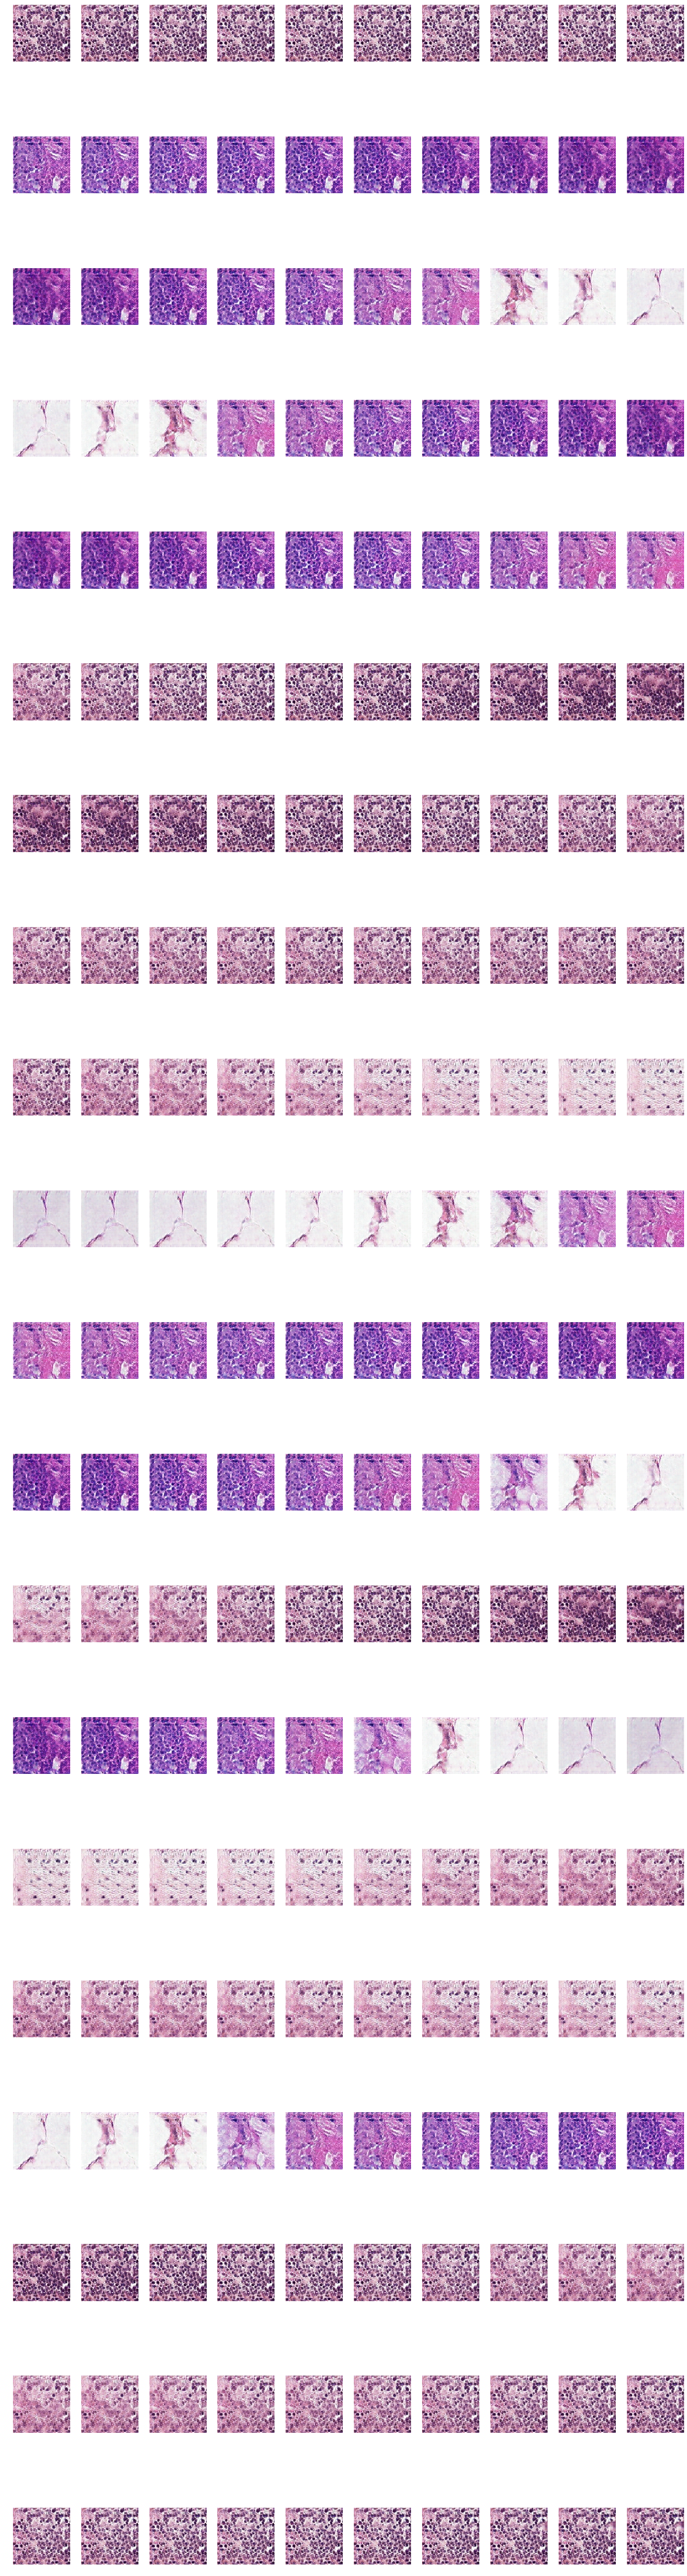

In [42]:
generator.load_weights('.\\AC-GAN with sample PCam data\\model\\g_model_912600000.h5')
vectors = randn(21*100).reshape(21, 100)
linfit_vectors = [interp1d([1,10], vectors[i:i+2, :], axis=0) for i in range(0, 20)]
interpolated_vectors = np.vstack([linfit_vectors[j]([i+1 for i in range(0, 10)]) for j in range(len(linfit_vectors))])
X = generator.predict([interpolated_vectors, np.repeat(randint(0, 2, 20), 10)])
X = ((X * 127.5) + 127.5).astype('uint8')
pyplot.figure(figsize=(25, 100))
for i in range(200):
    # define subplot
    pyplot.subplot(len(linfit_vectors), 10, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(X[i, :, :, :])

In [12]:
from timeit import timeit
import numpy as np
from numpy.random import shuffle

In [20]:
timeit('''import numpy as np
x = np.arange(10000)
perm = np.random.permutation(len(x))
x = x[perm]''', number=100)

0.03489434465872421

In [1]:
def func(**kwargs):
    print(type(kwargs))
    
func({'a':'b'})

TypeError: func() takes 0 positional arguments but 1 was given